In [80]:
from matplotlib import pyplot as plt
import numpy as np

from transit_chem.basis import HarmonicOscillator, harmonic_basis_from_parabola
from transit_chem import operators as op
from transit_chem import oneD
from transit_chem.utils import pairwise_array_from_func

triple_well = oneD.TripleWellPotential.from_params(
    well1_depth=0.8,
    well1_halfwidth=1.0,
    bridge_length=8.0,
    bridge_depth=0.5,
    well3_halfwidth=1.0,
    well3_depth=0.5,
)

cutoff_energy = 2
basis = (
    harmonic_basis_from_parabola(triple_well.well1, cutoff_energy=cutoff_energy)
    + harmonic_basis_from_parabola(triple_well.well2, cutoff_energy=1)
    + harmonic_basis_from_parabola(triple_well.well3, cutoff_energy=cutoff_energy)
)

(-1, 1.5)

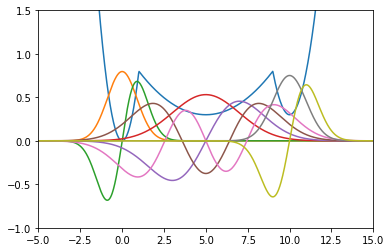

In [81]:
x = np.linspace(-10, 15, 1000)

plt.plot(x, triple_well(x))
for b in basis:
    plt.plot(x, b(x))
    
plt.xlim(-5, 15)
plt.ylim(-1, 1.5)

In [82]:
S = pairwise_array_from_func(basis, op.overlap, symmetric=True)
H = pairwise_array_from_func(basis, op.Hamiltonian(triple_well), symmetric=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.99it/s]


In [83]:
from scipy.linalg import eigh


In [84]:
eigvals, eigvecs = eigh(H, S)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
eigvecs /= np.linalg.norm(eigvecs, axis=0)

np.set_printoptions(precision=3, suppress=True,linewidth=500, threshold=10000)

print("S = \n", S)
print("H = \n", H)
print("Eigvals\n", eigvals)
print("Eigvecs\n", eigvecs)

S = 
 [[ 1.     0.     0.063 -0.187  0.361 -0.512  0.    -0.   ]
 [ 0.     1.     0.083 -0.199  0.277 -0.209  0.    -0.   ]
 [ 0.063  0.083  1.    -0.     0.    -0.     0.073 -0.104]
 [-0.187 -0.199 -0.     1.    -0.    -0.     0.208 -0.235]
 [ 0.361  0.277  0.    -0.     1.    -0.     0.384 -0.308]
 [-0.512 -0.209 -0.    -0.    -0.     1.     0.526 -0.211]
 [ 0.     0.     0.073  0.208  0.384  0.526  1.     0.   ]
 [-0.    -0.    -0.104 -0.235 -0.308 -0.211  0.     1.   ]]
H = 
 [[ 0.599 -0.079  0.    -0.034  0.127 -0.261 -0.     0.   ]
 [-0.079  1.699  0.029 -0.119  0.236 -0.241 -0.     0.   ]
 [ 0.     0.029  0.423  0.001 -0.014  0.004  0.012 -0.041]
 [-0.034 -0.119  0.001  0.652  0.008 -0.075  0.074 -0.153]
 [ 0.127  0.236 -0.014  0.008  0.821  0.025  0.219 -0.302]
 [-0.261 -0.241  0.004 -0.075  0.025  0.912  0.431 -0.34 ]
 [-0.    -0.     0.012  0.074  0.219  0.431  0.762  0.086]
 [ 0.     0.    -0.041 -0.153 -0.302 -0.34   0.086  1.595]]
Eigvals
 [0.417 0.54  0.659 0.832 1.038 1.

(-1, 1)

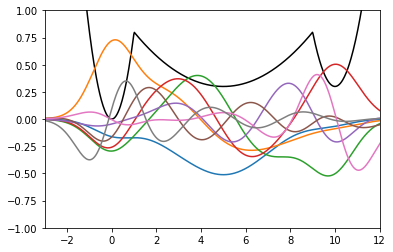

In [85]:
class LinearComb:
    def __init__(self, c, f):
        self.c = c
        self.f = f
    def __call__(self, x):
        return sum(ci * fi(x) for ci, fi in zip(self.c, self.f))
    def __repr__(self):
        return " + ".join(f"{c} * {f}" for c, f in zip(self.c, self.f))

eigenbasis = [LinearComb(c, basis) for c in eigvecs.T]
plt.plot(x, triple_well(x), color="k")
for b in eigenbasis:
    plt.plot(x, b(x))

plt.xlim(-3, 12)
plt.ylim(-1, 1)